In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import stats

import matplotlib.pyplot as plt

In [5]:
loan_data = pd.read_csv("./data/loans_full_schema.csv")

In [6]:
loan_data.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


# EDA

Modeling notes:
- `emp_title` - could do categorization? or some kind of cleaning
- `emp_length`- convert to int. standardize
- `homeownership` - convert to category
- `annual_income` - some outliers. standardize and remove outliers?
- `verified_income` ?
- 


In [7]:
loan_data['emp_title'].value_counts().head(10)

emp_title
manager             218
owner               204
teacher             201
driver              123
sales                97
registered nurse     88
rn                   80
supervisor           79
truck driver         63
office manager       61
Name: count, dtype: int64

<AxesSubplot:>

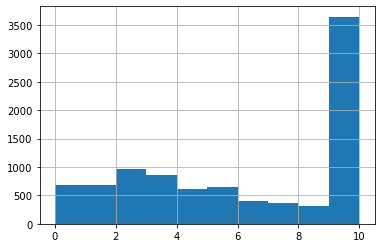

In [8]:
loan_data['emp_length'].hist()

In [9]:
loan_data['emp_length'].describe()

count    9183.000000
mean        5.930306
std         3.703734
min         0.000000
25%         2.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: emp_length, dtype: float64

In [10]:
loan_data['homeownership'].value_counts()

homeownership
MORTGAGE    4789
RENT        3858
OWN         1353
Name: count, dtype: int64

array([[<AxesSubplot:title={'center':'annual_income'}>]], dtype=object)

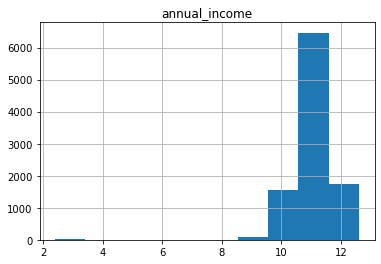

In [30]:
pd.DataFrame(np.log1p(loan_data[loan_data['annual_income']<3e5]['annual_income']+10)).hist()

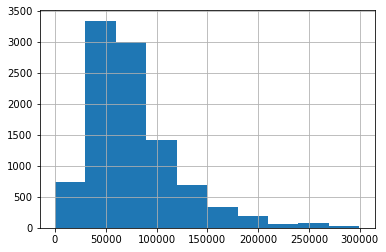

In [12]:
loan_data[loan_data['annual_income']<3e5]['annual_income'].hist();

In [28]:
loan_data['annual_income'].describe()

count    1.000000e+04
mean     7.922215e+04
std      6.473429e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.500000e+04
max      2.300000e+06
Name: annual_income, dtype: float64

In [36]:
loan_data['annual_income'].quantile(0.01)

13163.76

In [17]:
loan_data['verified_income'].value_counts()

verified_income
Source Verified    4116
Not Verified       3594
Verified           2290
Name: count, dtype: int64

In [19]:
loan_data['loan_status'].value_counts()

loan_status
Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64

<AxesSubplot:>

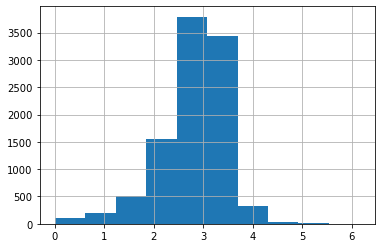

In [36]:
np.log1p(loan_data['debt_to_income']).hist()

<AxesSubplot:>

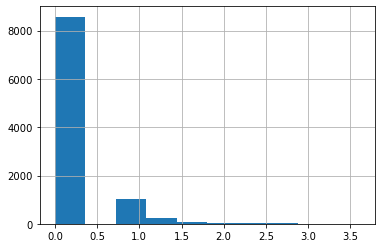

In [43]:
np.sqrt(loan_data['delinq_2y']).hist()

Modeling notes:
- `emp_title` - could do categorization? or some kind of cleaning
- `emp_length`- fillNA with 0. convert to int. [DONE]
- `homeownership` - convert to category
- `annual_income` - some outliers. standardize and remove outliers? [DONE]
- `verified_income` ?
- 

- define 'default' as `loan_status`='Late (31-120 days)' or 'Late (16-30 days)' or 'Charged Off'


# Data Cleaning

In [34]:
loan_data['emp_length'] = loan_data['emp_length'].fillna(0).astype(int)

In [37]:
loan_data['debt_to_income'] = np.log1p(loan_data['debt_to_income'])

In [38]:
loan_data['annual_income'] = loan_data['annual_income'].apply(lambda x: 3e5 if x>3e5 else x+10)
loan_data['annual_income'] = np.log1p(loan_data['annual_income'])

In [39]:
loan_data['default'] = loan_data['loan_status'].apply(lambda x: int(x in ['Late (16-30 days)', 'Late (31-120 days)', 'Charged Off']))
print(loan_data['default'].value_counts())

default
0    9889
1     111
Name: count, dtype: int64


In [7]:
loan_data.columns


Index(['emp_title', 'emp_length', 'state', 'homeownership', 'annual_income',
       'verified_income', 'debt_to_income', 'annual_income_joint',
       'verification_income_joint', 'debt_to_income_joint', 'delinq_2y',
       'months_since_last_delinq', 'earliest_credit_line',
       'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
       'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankr